In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB
from sklearn.model_selection import train_test_split

## Create sample data

In [81]:
# Function to generate samples for loads and wind production
def generate_samples(num_samples, loads, sd, wind_limits, wind_shape):
    data = []
    sd = [mean * sd for mean in loads] # Standard deviation for loads

    for sample_num in range(1, num_samples + 1):
        for hour in range(24):  # Fixed to 24 hours per day
            
            # Generate loads using normal distribution
            load_sample = [
                round(np.clip(np.random.normal(mean, std), 0, mean * 2), 2) 
                for mean, std in zip(loads, sd)
            ]  # Clipping to avoid unrealistic negative values or extreme high values
            
            # Generate wind production using Weibull distribution (typically skewed as most wind clusters around lower speed)
            wind_sample = [
                round(min(np.random.weibull(wind_shape) * 0.42 * limit, limit), 2) 
                for limit in wind_limits
            ]
            
            # Combine into one row with [Sample Number, Hour, L1, L2, L3, W1, W2]
            row = [sample_num, hour] + load_sample + wind_sample
            data.append(row)
    
    return data

# Load L1-L3 and wind capacity W1-W2
loads = [56, 112, 120]  # Mean values for L1, L2, L3
wind_limits = [10, 30]  # Maximum capacity for W1 and W2

# Generate data for the samples
samples_data = generate_samples(num_samples=1000, loads=loads, sd=0.10, 
                                wind_limits=wind_limits, wind_shape=1.1)

# Create column names for the DataFrame
columns = ["Sample_Nr", "Hour", "L1", "L2", "L3", "W1", "W2"] # Sample_Nr ~ Day

# Create the DataFrame
samples_df = pd.DataFrame(samples_data, columns=columns)

# Save to CSV
samples_df.to_csv("sample_simon.csv", index=False)

# Display the updated DataFrame structure
samples_df.head(30)

,Sample_Nr,Hour,L1,L2,L3,W1,W2
0,1,0,55.47,132.03,117.88,10.00,10.94
1,1,1,56.89,124.30,119.47,1.46,30.00
2,1,2,59.30,105.03,132.24,0.70,0.36
3,1,3,58.09,116.49,122.62,1.59,9.52
4,1,4,52.69,114.84,101.13,2.18,30.00
5,1,5,53.97,116.22,121.09,5.24,8.26
6,1,6,59.23,94.85,127.91,8.96,16.32
7,1,7,53.11,103.02,113.93,0.60,10.21
8,1,8,61.32,117.68,115.32,1.46,25.81
9,1,9,61.04,124.47,137.20,1.80,1.59


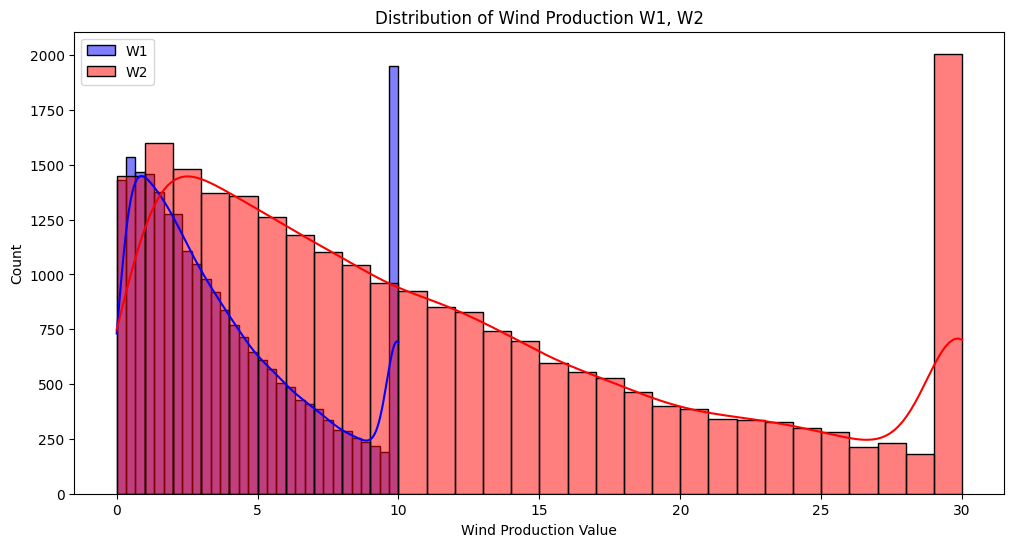

In [82]:
# Plot distribution of Wind Production
plt.figure(figsize=(12, 6))
sns.histplot(data=samples_df, x="W1", kde=True, bins=30, color="blue", label="W1")
sns.histplot(data=samples_df, x="W2", kde=True, bins=30, color="red", label="W2")
plt.title("Distribution of Wind Production W1, W2")
plt.xlabel('Wind Production Value')
plt.legend()
plt.show()

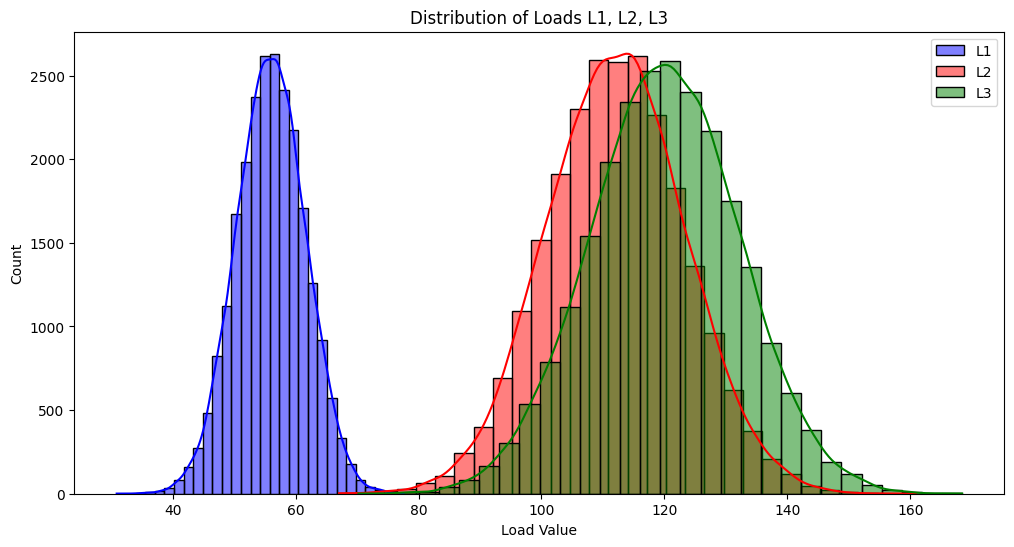

In [26]:
# Plot of distribution of Loads
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.histplot(data=samples_df, x="L1", kde=True, bins=30, color="blue", label="L1")
sns.histplot(data=samples_df, x="L2", kde=True, bins=30, color="red", label="L2")
sns.histplot(data=samples_df, x="L3", kde=True, bins=30, color="green", label="L3")
plt.title("Distribution of Loads L1, L2, L3")
plt.xlabel('Load Value')
plt.legend()
plt.show()

Further testing & tweaks

In [100]:
# Function to generate samples for loads and wind production with final refinements
def generate_samples(num_samples, loads, sd, wind_limits, wind_shape):
    data = []
    sd = [mean * sd for mean in loads]  # Standard deviation for loads

    for sample_num in range(1, num_samples + 1):
        daily_variability = 0.8 + 0.2 * np.clip(np.random.normal(0.5,0.2),0, 1)  # Simulate daily variability (0.9 to 1.2)
        
        for hour in range(24):  # Fixed to 24 hours per day
            # Generate loads using normal distribution
            load_sample = [
                round(np.clip(np.random.normal(mean, std), 0, mean * 2), 2) 
                for mean, std in zip(loads, sd)
            ]  # Clipping to avoid unrealistic negative values or extreme high values
            
            # Generate wind production -> distinction between W1 and W2 + daily variability
            wind_sample = [
                round(min((np.random.weibull(wind_shape) * (0.50 if limit == 10 else 0.45) * limit), limit * daily_variability), 2)
                for limit in wind_limits
            ]
            
            # Combine into one row with [Sample Number, Hour, L1, L2, L3, W1, W2]
            row = [sample_num, hour] + load_sample + wind_sample
            data.append(row)
    
    return data

# Load L1-L3 and wind capacity W1-W2
loads = [56, 112, 120]  # Mean values for L1, L2, L3
wind_limits = [10, 30]  # Maximum capacity for W1 and W2

# Generate data for the samples with final refinements
samples_data = generate_samples(num_samples=1000, loads=loads, sd=0.10, 
                                wind_limits=wind_limits, wind_shape=1.1)

# Create column names for the DataFrame
columns = ["Sample_Nr", "Hour", "L1", "L2", "L3", "W1", "W2"]  # Sample_Nr ~ Day

# Create the DataFrame
samples_df = pd.DataFrame(samples_data, columns=columns)

# Save to CSV
samples_df.to_csv("sample_simon.csv", index=False)

# Display the updated DataFrame structure
samples_df.head(30)


,Sample_Nr,Hour,L1,L2,L3,W1,W2
0,1,0,44.84,107.91,124.86,2.77,4.27
1,1,1,58.38,132.92,97.42,1.16,0.87
2,1,2,55.48,108.31,119.31,6.19,4.75
3,1,3,58.89,119.25,116.65,1.87,0.83
4,1,4,65.99,105.58,125.53,4.71,5.54
5,1,5,59.38,116.09,120.74,0.13,1.88
6,1,6,57.15,128.40,126.00,1.38,10.18
7,1,7,47.29,111.70,112.72,6.59,20.59
8,1,8,54.86,101.47,123.38,3.48,3.61
9,1,9,64.78,107.37,116.19,1.98,7.69


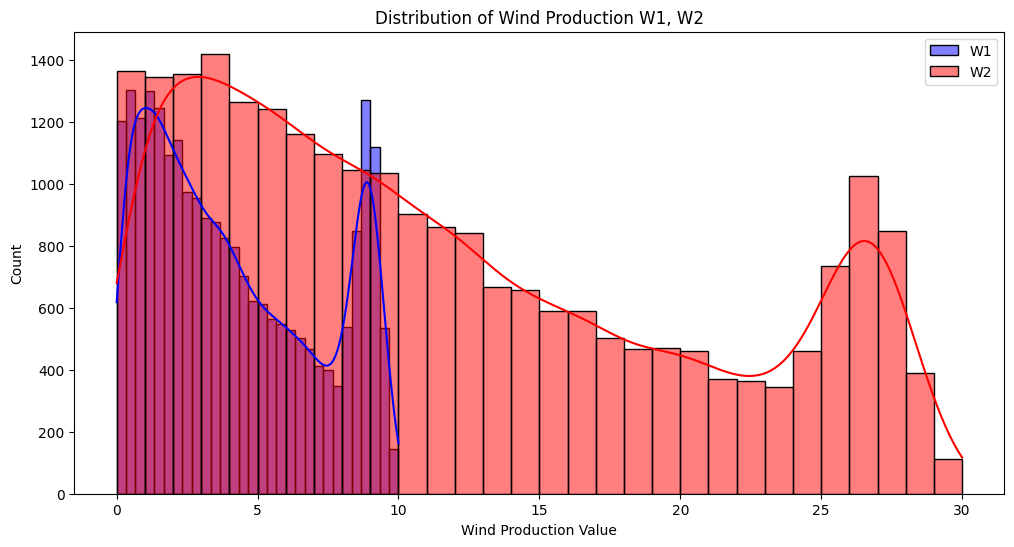

In [101]:
# Plot distribution of Wind Production
plt.figure(figsize=(12, 6))
sns.histplot(data=samples_df, x="W1", kde=True, bins=30, color="blue", label="W1")
sns.histplot(data=samples_df, x="W2", kde=True, bins=30, color="red", label="W2")
plt.title("Distribution of Wind Production W1, W2")
plt.xlabel('Wind Production Value')
plt.legend()
plt.show()

## Task 1] Build the optimisation model

In [24]:
# Load the data from the data folder
wind_forecast = pd.read_csv('Data/1.Wind forecast profile.csv', delimiter=';')
load = pd.read_csv('Data/1.Load profile.csv', delimiter=';')
bus = pd.read_csv('Data/B (power transfer factor of each bus to each line).csv', delimiter=';')
max_prod = pd.read_csv('Data/Maximum production of generating units.csv', delimiter=';')
min_prod = pd.read_csv('Data/Minimum production of generating units.csv', delimiter=';')
min_down_time = pd.read_csv('Data/Minimum down time of generating units.csv', delimiter=';')
min_up_time = pd.read_csv('Data/Minimum up time of generating units.csv', delimiter=';')
prod_cost = pd.read_csv('Data/Production cost of generating units.csv', delimiter=';')
ramp_rate = pd.read_csv('Data/Ramping rate of generating units.csv', delimiter=';')
start_up_cost = pd.read_csv('Data/Start-up cost of generating units.csv', delimiter=';')
transmission_cap = pd.read_csv('Data/Transmission capacity of lines.csv', delimiter=';')




# wind_forecast = pd.read_csv('Data/1.Wind forecast profile.csv', delimiter=';')
# load = pd.read_csv('Data/1.Load profile.csv', delimiter=';')
samples = pd.read_csv('samples.csv', delimiter=',')

# Now proceed to combine columns if the column names are correct
load_tot = samples[['Hour','Load_L1', 'Load_L2', 'Load_L3']]
wind_forecast_tot = samples[['Hour','Wind_W1', 'Wind_W2']]

# print(load)
# print(wind_forecast)
print(load_tot)

       Hour  Load_L1  Load_L2  Load_L3
0         0      120       56      112
1         1      120      112       56
2         2      120      120      112
3         3      112      120      120
4         4      120      112       56
...     ...      ...      ...      ...
23995    19       56      120      120
23996    20       56      112       56
23997    21      120      112      112
23998    22      120      112      120
23999    23      112       56       56

[24000 rows x 4 columns]


In [3]:
Nodes = ['Node 1', 'Node 2', 'Node 3', 'Node 4', 'Node 5', 'Node 6']
Generator = ['G1', 'G2', 'G3']
Generator_node = {'Node 1': 'G1', 'Node 2': 'G2', 'Node 6': 'G3'}
Load = ['L1', 'L2', 'L3']
Load_node = {'Node 4': 'L1', 'Node 5': 'L2', 'Node 6': 'L3'}
Wind = ['W1', 'W2']
Wind_node = {'Node 4': 'W1', 'Node 5': 'W2'}

In [4]:
# Create matrix with the nodes as columns and the generators, loads and winds as rows, with 1 if connected to the node
Gen_n = np.zeros((len(Generator), len(Nodes)))
Load_n = np.zeros((len(Load), len(Nodes)))
Wind_n = np.zeros((len(Wind), len(Nodes)))

# Populate the matrix
for i, g in enumerate(Generator):  # Iterate over generators
    for j, node in enumerate(Nodes):  # Iterate over nodes
        if Generator_node.get(node) == g:  # Check if generator is connected to the node
            Gen_n[i, j] = 1

for i, l in enumerate(Load):  # Iterate over loads
    for j, node in enumerate(Nodes):  # Iterate over nodes
        if Load_node.get(node) == l:  # Check if load is connected to the node
            Load_n[i, j] = 1

for i, w in enumerate(Wind):  # Iterate over winds
    for j, node in enumerate(Nodes):  # Iterate over nodes
        if Wind_node.get(node) == w:  # Check if wind is connected to the node
            Wind_n[i, j] = 1
            


In [5]:
# Define the input data class
class InputData:
    
    def __init__(
        self,
        wind_forecast: pd.DataFrame, 
        bus: pd.DataFrame,
        load: pd.DataFrame,
        max_prod: pd.DataFrame,
        min_prod: pd.DataFrame,
        min_down_time: pd.DataFrame,
        min_up_time: pd.DataFrame,
        prod_cost: pd.DataFrame,
        ramp_rate: pd.DataFrame,
        start_up_cost: pd.DataFrame,
        transmission_cap: pd.DataFrame
    ):
        self.time = wind_forecast['Hour']  #maybe define it with lenght of wind_production
        self.wind_forecast = wind_forecast
        self.bus = bus
        self.load = load
        self.max_prod = max_prod
        self.min_prod = min_prod
        self.min_down_time = min_down_time
        self.min_up_time = min_up_time
        self.prod_cost = prod_cost
        self.ramp_rate = ramp_rate
        self.start_up_cost = start_up_cost
        self.transmission_cap = transmission_cap
        self.M = 1000000  # Penalty for having flexible demand
        self.Gen_n = Gen_n  # Matrix mapping generators to nodes
        self.Load_n = Load_n # Matrix mapping loads to nodes
        self.Wind_n = Wind_n # Matrix mapping wind to nodes
        
        


In [6]:
class Expando(object):
    '''
        A small class which can have attributes set
    '''
    pass

In [42]:
# Define the optimization model class

class EconomicDispatch():
        
        def __init__(self, input_data: InputData):
            self.data = input_data 
            self.variables = Expando()
            self.constraints = Expando() 
            self.results = Expando() 
            self._build_model() 
            
        def _build_variables(self):
            # one binary variable for the status of each generator
            self.variables.status = {
                (i, t): self.model.addVar(vtype=GRB.BINARY, 
                                            name='status_G{}_{}'.format(i, t)) 
                                            for i in range(1, len(self.data.max_prod)+1) 
                                            for t in self.data.time}
            
            # one variable for each generator for each time of the day
            self.variables.prod_gen = {
                 (i, t): self.model.addVar(lb=0, ub=self.data.max_prod.iloc[i-1, 0], 
                                           name='generation_G{}_{}'.format(i, t)) 
                                           for i in range(1, len(self.data.max_prod)+1) 
                                           for t in self.data.time}
            
            # one variable for each wind generator for each time of the day
            self.variables.prod_wind = {
                 (i, t): self.model.addVar(lb=0, ub=self.data.wind_forecast.iloc[t, i], 
                                            name='wind_generation_W{}_{}'.format(i, t)) 
                                            for i in range(1, len(self.data.wind_forecast.iloc[0, :])) 
                                            for t in self.data.time}
            
            # one variable for each start-up cost for each generator
            self.variables.start_up_cost = {
                 (i, t): self.model.addVar(lb=0, 
                                            name='start_up_cost_G{}_{}'.format(i, t)) 
                                            for i in range(1, len(self.data.max_prod)+1) 
                                            for t in self.data.time}
            
            # add two slack variables to always make the model feasible, allowing the demand to be flexible
            self.variables.epsilon = {
                 (n, t): self.model.addVar(lb=0, 
                                           name='epsilon_Bus{}_{}'.format(n, t)) 
                                           for n in range(1, len(self.data.bus.iloc[0,:])+1) 
                                           for t in self.data.time}
            self.variables.delta = {
                 (n, t): self.model.addVar(lb=0, 
                                           name='delta_Bus{}_{}'.format(n, t))
                                           for n in range(1, len(self.data.bus.iloc[0,:])+1)
                                           for t in self.data.time}
            
            
        def _build_constraints(self):
            # Minimum capacity of the generator
            self.constraints.min_capacity = {
                (i, t): self.model.addConstr(
                    self.variables.prod_gen[i, t] >= self.data.min_prod.iloc[i-1, 0] * self.variables.status[i, t]
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time}
            # Maximum capacity of the generator
            self.constraints.max_capacity = {
                (i, t): self.model.addConstr(
                    self.variables.prod_gen[i, t] <= self.data.max_prod.iloc[i-1, 0] * self.variables.status[i, t]
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time}

            # Power balance constraint
            self.constraints.power_balance = {
                t: self.model.addConstr(
                    gp.quicksum(self.variables.prod_gen[i, t] for i in range(1, len(self.data.max_prod)+1)) + 
                    gp.quicksum(self.variables.prod_wind[i, t] for i in range(1, len(self.data.wind_forecast.iloc[0, :]))) == 
                    gp.quicksum(self.data.load.iloc[t, i] * Load_n[i-1, n-1] + self.variables.epsilon[n, t] - self.variables.delta[n, t] 
                        for i in range(1, len(self.data.load.iloc[0, :]))
                        for n in range(1, len(self.data.bus.iloc[0,:])+1))
                ) for t in self.data.time}

            # Transmission capacity constraint
            self.constraints.transmission_capacity_up = {
                    (l, t): self.model.addConstr(
                        gp.quicksum(self.data.bus.iloc[l-1, n-1] *
                                (self.variables.prod_gen[i, t] * Gen_n[i-1, n-1] +
                                self.variables.prod_wind[i, t] * Wind_n[i-1, n-1] -
                                self.variables.epsilon[n, t] +
                                self.variables.delta[n, t]) for n in range(1, len(self.data.bus.iloc[0,:])+1)) <=
                        self.data.transmission_cap.iloc[l-1, 0]
                    ) for l in range(1, len(self.data.transmission_cap)+1)
                    for t in self.data.time}
            self.constraints.transmission_capacity_down = {
                    (l, t): self.model.addConstr(
                        gp.quicksum(self.data.bus.iloc[l-1, n-1] *
                                (self.variables.prod_gen[i, t] * Gen_n[i-1, n-1] +
                                self.variables.prod_wind[i, t] * Wind_n[i-1, n-1] -
                                self.variables.epsilon[n, t] +
                                self.variables.delta[n, t]) for n in range(1, len(self.data.bus.iloc[0,:])+1)) >=
                        -self.data.transmission_cap.iloc[l-1, 0]
                    ) for l in range(1, len(self.data.transmission_cap)+1)
                    for t in self.data.time}
                                     




            #Start-up costs constraint
            self.constraints.start_up_cost = {
                (i, t): self.model.addConstr(
                    self.variables.start_up_cost[i, t] >= self.data.start_up_cost.iloc[i-1, 0] * (self.variables.status[i, t] - self.variables.status[i, t-1])
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time if t > 0}
            self.constraints.start_up_cost_0 = {
                i: self.model.addConstr(
                    self.variables.start_up_cost[i, 0] >= self.data.start_up_cost.iloc[i-1, 0] * self.variables.status[i, 0]
                ) for i in range(1, len(self.data.max_prod)+1)}
            
            # Ramping constraint
            self.constraints.ramping_up = {
                (i, t): self.model.addConstr(
                    self.variables.prod_gen[i, t] - self.variables.prod_gen[i, t-1] <= self.data.ramp_rate.iloc[i-1, 0]
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time if t > 0}
            self.constraints.ramping_down = {
                (i, t): self.model.addConstr(
                    self.variables.prod_gen[i, t-1] - self.variables.prod_gen[i, t] <= self.data.ramp_rate.iloc[i-1, 0]
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time if t > 0}
            
            # Minimum up time constraint
            self.constraints.min_up_time = {
                (i, t, to): self.model.addConstr(
                    -self.variables.status[i, t - 1] + self.variables.status[i, t] - self.variables.status[i, to] <= 0
                ) for i in range(1, len(self.data.max_prod) + 1) 
                for t in self.data.time 
                for to in range(t, min(t + self.data.min_up_time.iloc[i-1, 0], 24)) if t > 0  # Ensure to does not exceed 23
            }


            
            # Minimum down time constraint
            self.constraints.min_down_time = {
                (i, t, to): self.model.addConstr(
                    self.variables.status[i, t - 1] - self.variables.status[i, t] + self.variables.status[i, to] <= 1
                ) for i in range(1, len(self.data.max_prod)+1) 
                for t in self.data.time 
                for to in range(t, min(t + self.data.min_down_time.iloc[i-1, 0], 24)) if t > 0}
            


        def _build_objective(self):
            # Objective function
            self.model.setObjective(
                gp.quicksum(self.data.prod_cost.iloc[i-1, 0]*self.variables.prod_gen[i, t] for i in range(1, len(self.data.max_prod)+1) for t in self.data.time) +
                gp.quicksum(self.variables.start_up_cost[i, t] for i in range(1, len(self.data.max_prod)+1) for t in self.data.time) +
                self.data.M * (gp.quicksum(self.variables.epsilon[n, t] + self.variables.delta[n, t] for n in range(1, len(self.data.bus.iloc[0,:])+1) for t in self.data.time))
            )

        def _build_model(self):
            self.model = gp.Model('EconomicDispatch')
            self._build_variables()
            self._build_constraints()
            self._build_objective()
            self.model.update()

        def optimize(self):
            self.model.optimize()
            self._extract_results()

        def _extract_results(self):
            self.results.production = pd.DataFrame({
                #'time': [t for t in self.data.time],
                #'status G1': [self.variables.status[1, t].x for t in self.data.time],
                #'status G2': [self.variables.status[2, t].x for t in self.data.time],
                #'status G3': [self.variables.status[3, t].x for t in self.data.time],
                #'start_up_cost 1': [self.variables.start_up_cost[1, t].x for t in self.data.time],
                #'start_up_cost 2': [self.variables.start_up_cost[2, t].x for t in self.data.time],
                #'start_up_cost 3': [self.variables.start_up_cost[3, t].x for t in self.data.time],
                'generation 1': [self.variables.prod_gen[1, t].x for t in self.data.time],
                'generation 2': [self.variables.prod_gen[2, t].x for t in self.data.time],
                'generation 3': [self.variables.prod_gen[3, t].x for t in self.data.time],
                'wind generation 1': [self.variables.prod_wind[1, t].x for t in self.data.time],
                'wind generation 2': [self.variables.prod_wind[2, t].x for t in self.data.time],
                'load 1': [self.data.load.iloc[t, 1] for t in self.data.time],
                'load 2': [self.data.load.iloc[t, 2] for t in self.data.time],
                'load 3': [self.data.load.iloc[t, 3] for t in self.data.time],
                'epsilon 1': [self.variables.epsilon[1, t].x for t in self.data.time],
                'delta 1': [self.variables.delta[1, t].x for t in self.data.time],
                'epsilon 2': [self.variables.epsilon[2, t].x for t in self.data.time],
                'delta 2': [self.variables.delta[2, t].x for t in self.data.time],
                'epsilon 3': [self.variables.epsilon[3, t].x for t in self.data.time],
                'delta 3': [self.variables.delta[3, t].x for t in self.data.time],
                'epsilon 4': [self.variables.epsilon[4, t].x for t in self.data.time],
                'delta 4': [self.variables.delta[4, t].x for t in self.data.time],
                'epsilon 5': [self.variables.epsilon[5, t].x for t in self.data.time],
                'delta 5': [self.variables.delta[5, t].x for t in self.data.time],
                'epsilon 6': [self.variables.epsilon[6, t].x for t in self.data.time],
                'delta 6': [self.variables.delta[6, t].x for t in self.data.time]
            })
            self.results.unit_commitment = pd.DataFrame({
                'time': [t for t in self.data.time],
                'G1': [self.variables.status[1, t].x for t in self.data.time],
                'G2': [self.variables.status[2, t].x for t in self.data.time],
                'G3': [self.variables.status[3, t].x for t in self.data.time]
            })
            

In [43]:
# Run the model
input_data = InputData(wind_forecast_tot, bus, load_tot, max_prod, min_prod, min_down_time, min_up_time, prod_cost, ramp_rate, start_up_cost, transmission_cap)
model = EconomicDispatch(input_data)
model.optimize()
model.results.production


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-11400H @ 2.70GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1040003 rows, 552000 columns and 5586006 nonzeros
Model fingerprint: 0x80d2e2ff
Variable types: 480000 continuous, 72000 integer (72000 binary)
Coefficient statistics:
  Matrix range     [7e-02, 9e+02]
  Objective range  [1e+03, 1e+09]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e+00, 4e+02]
Found heuristic solution: objective 2.234000e+12
Presolve removed 138003 rows and 551451 columns
Presolve time: 1.36s
Presolved: 902000 rows, 549 columns, 5448000 nonzeros
Variable types: 408 continuous, 141 integer (72 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.070000e+02   0.000000e+00      8s
     137    1.0450600e+10   0.000000

,generation 1,generation 2,generation 3,wind generation 1,wind generation 2,load 1,load 2,load 3,epsilon 1,delta 1,epsilon 2,delta 2,epsilon 3,delta 3,epsilon 4,delta 4,epsilon 5,delta 5,epsilon 6,delta 6
0,128.0,100.0,0.0,30.0,30.0,120,56,112,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,148.0,100.0,0.0,10.0,30.0,120,112,56,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,192.0,100.0,0.0,30.0,30.0,120,120,112,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,212.0,100.0,0.0,30.0,10.0,112,120,120,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,157.0,91.0,0.0,30.0,10.0,120,112,56,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,112.0,100.0,0.0,10.0,10.0,120,56,56,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23996,156.0,100.0,0.0,30.0,10.0,56,120,120,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23997,118.0,50.0,0.0,0.0,0.0,56,56,56,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23998,173.0,100.0,20.0,10.0,10.0,112,112,120,0.0,10.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
model.results.unit_commitment #to be used for the next steps

,time,G1,G2,G3
0,0,1.0,1.0,0.0
1,1,1.0,1.0,0.0
2,2,1.0,1.0,0.0
3,3,1.0,1.0,0.0
4,4,1.0,1.0,0.0
...,...,...,...,...
23995,19,1.0,1.0,0.0
23996,20,1.0,1.0,0.0
23997,21,1.0,1.0,0.0
23998,22,1.0,1.0,1.0


## Step 2: Data preparation  


In [45]:
unit_commitment_df = model.results.unit_commitment

# Convert the float values to integers for the unit status columns (G1, G2, G3)
unit_commitment_df[['G1', 'G2', 'G3']] = unit_commitment_df[['G1', 'G2', 'G3']].astype(int)

# Define features and labels
# Assuming that 'time' can be used as an index or feature
features = unit_commitment_df[['time']]  # Add other features as needed
labels = unit_commitment_df[['G1', 'G2', 'G3']]  # Binary labels for each generator

# Split the dataset into training (60%), validation (20%), and testing (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display the split sizes
print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Testing set size:", X_test.shape, y_test.shape)

# Save the training, validation, and testing sets as CSV files if needed
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
X_val.to_csv('X_val.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)


Training set size: (14400, 1) (14400, 3)
Validation set size: (4800, 1) (4800, 3)
Testing set size: (4800, 1) (4800, 3)


## Step 3 Classification:

In [46]:
# Check label distribution for each unit
for unit in ['G1', 'G2', 'G3']:
    print(f"Label distribution for {unit}:")
    print(y_train[unit].value_counts())
    print()


Label distribution for G1:
G1
1    14400
Name: count, dtype: int64

Label distribution for G2:
G2
1    14400
Name: count, dtype: int64

Label distribution for G3:
G3
0    10790
1     3610
Name: count, dtype: int64



# Evaluation and Comparison of Classifier Performance

## Metrics for Evaluation:

### 1. **Accuracy**:
- **Definition**: The proportion of correct predictions out of the total number of samples.
- **Use Case**: Useful for understanding the overall correctness of the model's predictions.
- **Formula**: 
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

### 2. **Precision**:
- **Definition**: The proportion of true positive predictions among all positive predictions.
- **Use Case**: Important for problems where minimizing false positives is critical.
- **Formula**:
$$
\text{Precision} = \frac{TP}{TP + FP}
$$

### 3. **Recall (Sensitivity/True Positive Rate)**:
- **Definition**: The proportion of actual positive cases that were correctly identified.
- **Use Case**: Useful when the focus is on minimizing false negatives.
- **Formula**:
$$
\text{Recall} = \frac{TP}{TP + FN}
$$

### 4. **F1 Score**:
- **Definition**: The harmonic mean of precision and recall, balancing the trade-off between precision and recall.
- **Use Case**: A good metric when a balance between precision and recall is needed, especially in cases of imbalanced datasets.
- **Formula**:
$$
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

### 5. **Confusion Matrix**:
- **Definition**: A table showing the number of true positive, true negative, false positive, and false negative predictions.
- **Use Case**: Provides a complete view of how the model performs across different classes.



In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Dictionary to store trained models for each unit
trained_models = {}

# Function to train and evaluate classifiers
def train_and_evaluate(X_train, X_val, y_train, y_val, unit_name):
    # Check if the unit has samples for both classes
    if len(y_train[unit_name].unique()) < 2:
        print(f"Skipping training for {unit_name} as it only contains one class.")
        return

    # Dictionary to store models for this unit
    unit_models = {
        'Logistic Regression': LogisticRegression(),
        'SVM (RBF Kernel)': SVC(kernel='rbf')
    }
    results = {}

    # Train and evaluate each model
    for model_name, model in unit_models.items():
        # Train the model
        model.fit(X_train, y_train[unit_name])
        
        # Store the trained model
        trained_models[(unit_name, model_name)] = model
        
        # Predict on validation set
        y_pred = model.predict(X_val)
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y_val[unit_name], y_pred)
        precision = precision_score(y_val[unit_name], y_pred, zero_division=0)
        recall = recall_score(y_val[unit_name], y_pred, zero_division=0)
        f1 = f1_score(y_val[unit_name], y_pred, zero_division=0)
        
        # Store the results
        results[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        }
        
        print(f"\n{model_name} for {unit_name}:")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")
    
    return results

# Loop through each generating unit to train and evaluate models
for unit in ['G1', 'G2', 'G3']:
    print(f"\nTraining classifiers for {unit}:")
    train_and_evaluate(X_train, X_val, y_train, y_val, unit)



Training classifiers for G1:
Skipping training for G1 as it only contains one class.

Training classifiers for G2:
Skipping training for G2 as it only contains one class.

Training classifiers for G3:

Logistic Regression for G3:
Accuracy: 0.75
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

SVM (RBF Kernel) for G3:
Accuracy: 0.87
Precision: 1.00
Recall: 0.49
F1 Score: 0.66


In [36]:
print(trained_models)

{('G3', 'Logistic Regression'): LogisticRegression(), ('G3', 'SVM (RBF Kernel)'): SVC()}


In [37]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Function to evaluate and summarize performance
def evaluate_and_compare(X_test, y_test, trained_models, unit_name):
    results_summary = []

    for model_name, model in trained_models.items():
        # Predict on the test set
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test[unit_name], y_pred)
        precision = precision_score(y_test[unit_name], y_pred, zero_division=0)
        recall = recall_score(y_test[unit_name], y_pred, zero_division=0)
        f1 = f1_score(y_test[unit_name], y_pred, zero_division=0)

        # Append metrics to results summary
        results_summary.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

        # Print classification report and confusion matrix
        print(f"\nClassification Report for {model_name} - {unit_name}:\n")
        print(classification_report(y_test[unit_name], y_pred, zero_division=0))
        print(f"Confusion Matrix for {model_name} - {unit_name}:\n")
        print(confusion_matrix(y_test[unit_name], y_pred))
        print()

    # Create a DataFrame for summary
    results_df = pd.DataFrame(results_summary)
    print(f"\nPerformance Summary for {unit_name}:\n")
    print(results_df)

    return results_df

# Assuming `trained_models` is a dictionary containing trained models for each unit
for unit in ['G1', 'G2', 'G3']:
    print(f"\nEvaluating models for {unit}:")
    evaluate_and_compare(X_test, y_test, trained_models, unit)



Evaluating models for G1:

Classification Report for ('G3', 'Logistic Regression') - G1:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    4800.0

    accuracy                           0.00    4800.0
   macro avg       0.00      0.00      0.00    4800.0
weighted avg       0.00      0.00      0.00    4800.0

Confusion Matrix for ('G3', 'Logistic Regression') - G1:

[[   0    0]
 [4800    0]]


Classification Report for ('G3', 'SVM (RBF Kernel)') - G1:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    4800.0

    accuracy                           0.00    4800.0
   macro avg       0.00      0.00      0.00    4800.0
weighted avg       0.00      0.00      0.00    4800.0

Confusion Matrix for ('G3', 'SVM (RBF Kernel)') - G1:

[[   0    0]
 [4800    0]]


Performance Summary for 

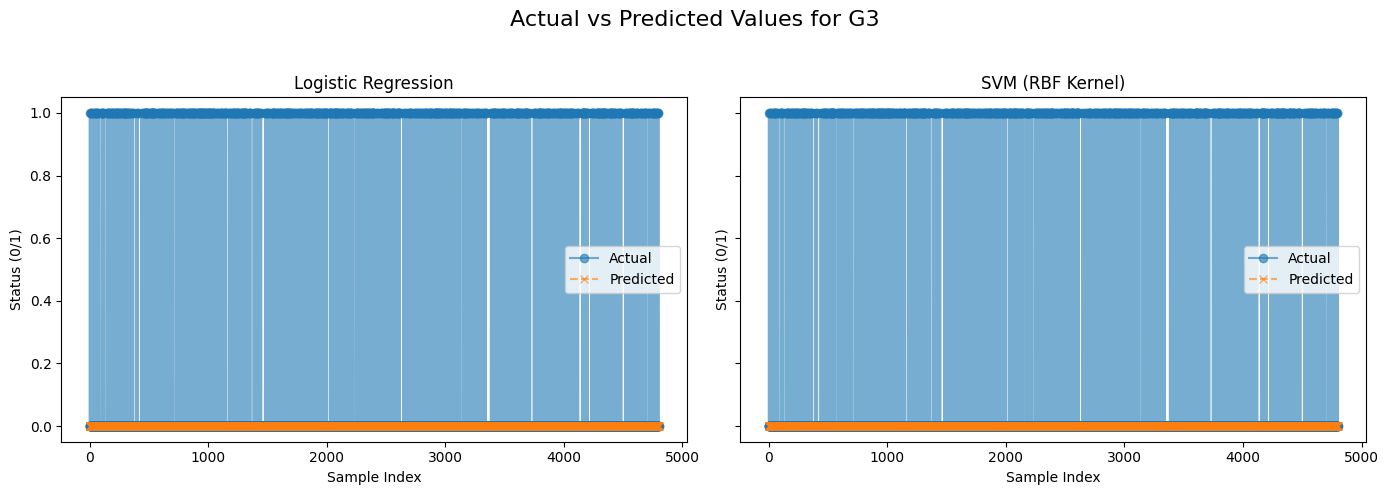

In [40]:
import matplotlib.pyplot as plt

# Function to plot actual vs predicted values for each unit and model
def plot_predictions(X_test, y_test, trained_models, unit_name):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    fig.suptitle(f'Actual vs Predicted Values for {unit_name}', fontsize=16)

    models = ['Logistic Regression', 'SVM (RBF Kernel)']
    
    for i, model_name in enumerate(models):
        model = trained_models.get((unit_name, model_name))
        if model:
            y_pred = model.predict(X_test)
            axes[i].plot(y_test[unit_name].values, label='Actual', marker='o', linestyle='-', alpha=0.6)
            axes[i].plot(y_pred, label='Predicted', marker='x', linestyle='--', alpha=0.6)
            axes[i].set_title(model_name)
            axes[i].set_xlabel('Sample Index')
            axes[i].set_ylabel('Status (0/1)')
            axes[i].legend()
        else:
            axes[i].text(0.5, 0.5, 'Model not available', horizontalalignment='center', verticalalignment='center')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plot for each unit
for unit in ['G3']:
    plot_predictions(X_test, y_test, trained_models, unit)
